# Building a Linear Factor Model

## Import

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

In [5]:
sns.set_style('whitegrid')

## Data

Kenneth French has high-quality factor data available from his Dartmouth website:
http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

It is super easy to access using `pandas_datareader`, which is what we're gonna do.

#### Fama-French 5-Factor Model

We are going to use the five factors from the famous Fama-French-Five-Factor Model (FFFFM). On French's website, these are:

* **SMB** - Small minus big. This factor is the difference in average return between a portfolio built of small-cap stocks and a portfolio built of large-cap stocks.

* **HML** - High minus low. This factor is the difference in average return between a portfolio built of value stocks (low price to book ratio) and a portfolio built of growth stocks (high price to book ratio).

* **RMW** - Robust minus weak. This factor is the difference in average return between a portfolio built of stocks from companies with robust operating profitability and a portfolio of built of stocks from companies with weak operating profitability.

* **CMA** - Conservative minus aggressive. This factor is the difference in the average return between conservative investment portfolios and aggressive investment portfolios.

* **Rm-Rf** - Excess return on the market. The value-weighted return of all firms on the market in month (t), minus the one-month T-Bill rate.

#### How the factors are calculated...

Here is a link to the paper in which Fama and French put forth this 5-Factor model in 2015.
https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002323?via%3Dihub

In the paper, they explain how each of the factors in calculated, and they explain the theoretical underpinnings of the model. Due to the dangers of data snooping, it is very important that any model that will be applied to actual portfolio management have a strong theoretical explanation. Without this economic basis, there is no reason whatsoever to think that future performance of the model will be similar to past performance. Always start with the theory, then see if the data supports your hypothesis. That's the scientific method.

Anyway, back to the factors. While the original authors do have factor data available to download from their websites, we need to understand the factors before we use them in practice.

The **SMB** factor is calculated as a 3x3 "matrix" of portfolios. The three other non-market factors are evaluated as a 3x2 "matrix" of portfolios. The market factor is more straightforward.

## Get the Data

#### Factor Data

In [6]:
ff_factors = 'F-F_Research_Data_5_Factors_2x3'
factor_data = web.DataReader(ff_factors, 'famafrench', start='2000', end='2020-12')
monthly_factor_data = factor_data[0]
yearly_factor_data = factor_data[1]

In [7]:
monthly_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
 5   RF      252 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


We have 21 years of factor data, from January 2000 to December 2020. There are no missing values, and everything so far looks good. The `RF` column is the risk-free rate, one-month T-Bill rate.

We can't really do much to the data without messing up the interpretation, so we won't be doing much for the Explore, Clean, Transform, and Engineer Features step of the ML Process. We are just going to make sure we have no missing values and look at descriptive statistics.

In [8]:
monthly_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,252.000000,252.000000,252.000000,252.000000,252.00000,252.00000
mean,0.548095,0.294683,0.072778,0.380833,0.24000,0.13004
std,4.570582,3.129659,3.261615,2.933445,1.98586,0.15008
min,-17.230000,-15.390000,-14.020000,-18.760000,-5.05000,0.00000
25%,-1.970000,-1.447500,-1.677500,-0.970000,-1.02000,0.01000
50%,1.135000,0.255000,-0.120000,0.370000,0.00000,0.08000
75%,3.262500,2.152500,1.585000,1.430000,1.27250,0.19000
max,13.650000,18.380000,12.480000,13.380000,9.06000,0.56000


In [9]:
monthly_factor_data.isna().sum().sum()

0

#### Portfolio Return Data

The website also has portfolio data available, which can be used to calculate the factors. We are going to bring in portfolio return data for each of the 17 standard industry portfolios.

In [10]:
ff_portfolios = '17_Industry_Portfolios'
portfolio_data = web.DataReader(ff_portfolios, 'famafrench', start='2000', end='2020-12')
monthly_portfolio_data = portfolio_data[0]
yearly_portfolio_data = portfolio_data[1]
monthly_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 252 entries, 2000-01 to 2020-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    252 non-null    float64
 1   Mines   252 non-null    float64
 2   Oil     252 non-null    float64
 3   Clths   252 non-null    float64
 4   Durbl   252 non-null    float64
 5   Chems   252 non-null    float64
 6   Cnsum   252 non-null    float64
 7   Cnstr   252 non-null    float64
 8   Steel   252 non-null    float64
 9   FabPr   252 non-null    float64
 10  Machn   252 non-null    float64
 11  Cars    252 non-null    float64
 12  Trans   252 non-null    float64
 13  Utils   252 non-null    float64
 14  Rtail   252 non-null    float64
 15  Finan   252 non-null    float64
 16  Other   252 non-null    float64
dtypes: float64(17)
memory usage: 35.4 KB


We have the same number of observations in each industry portfolio as we have for each factor. Perfect!

In [11]:
monthly_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.791587,0.986389,0.591548,1.226389,0.778294,0.837143,0.784722,0.933651,0.468016,1.124325,0.767302,1.069048,0.966468,0.836389,0.910119,0.698452,0.633492
std,3.548630,8.248933,6.950674,6.296852,6.368116,6.311410,3.762594,6.236488,9.165617,5.722333,7.431526,7.868745,5.452989,4.155060,4.614436,5.793738,5.060735
min,-12.970000,-32.760000,-34.690000,-22.170000,-25.820000,-21.930000,-10.130000,-20.280000,-32.910000,-23.030000,-29.070000,-27.810000,-22.680000,-13.010000,-14.590000,-20.910000,-17.830000
25%,-1.062500,-4.965000,-2.960000,-2.085000,-2.697500,-2.172500,-1.570000,-2.920000,-4.660000,-1.757500,-2.992500,-2.960000,-1.847500,-0.945000,-1.617500,-2.310000,-2.132500
50%,0.960000,0.735000,0.790000,1.415000,1.115000,1.230000,1.155000,1.625000,0.615000,1.665000,1.450000,0.755000,1.395000,1.415000,0.870000,1.230000,1.275000
75%,3.150000,6.837500,4.532500,4.837500,4.435000,4.422500,3.327500,4.667500,6.227500,4.800000,4.805000,4.825000,4.215000,3.560000,3.617500,3.857500,3.607500
max,13.460000,21.940000,32.870000,23.340000,29.410000,20.110000,10.390000,17.990000,26.250000,18.820000,20.070000,38.720000,19.700000,11.730000,18.270000,17.120000,13.550000


#### Equity Data

We have all that data we downloaded before, which includes a bunch of stock prices. Let's bring that in!

In [12]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices']['adj_close'].unstack().loc['2000':'2020']
    stocks = store['/us_equities/stocks'].drop_duplicates()

In [13]:
sectors = stocks.filter(prices.columns, axis=0)['sector'].to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [14]:
returns = prices.resample("M").last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 218 entries, 2000-02 to 2018-03
Freq: M
Columns: 1229 entries, A to ZIXI
dtypes: float64(1229)
memory usage: 2.0 MB


#### Align the Data

In [15]:
monthly_factor_data = monthly_factor_data.loc[returns.index]
monthly_portfolio_data = monthly_portfolio_data.loc[returns.index]

monthly_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.448853,0.336101,0.326101,0.469128,0.296835,0.130000
std,4.337868,3.126592,3.153359,3.065464,2.007236,0.157679
min,-17.230000,-15.390000,-11.110000,-18.760000,-5.050000,0.000000
25%,-1.967500,-1.420000,-1.260000,-0.890000,-1.005000,0.000000
50%,1.060000,0.220000,0.040000,0.435000,0.000000,0.070000
75%,3.130000,2.295000,1.760000,1.595000,1.357500,0.210000
max,11.350000,18.380000,12.480000,13.380000,9.060000,0.560000


In [16]:
monthly_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.800321,0.899266,0.777248,1.187431,0.605138,0.959266,0.727431,0.901835,0.540917,1.049862,0.629312,0.616009,1.050963,0.816468,0.803761,0.692890,0.469954
std,3.355312,8.281407,5.807512,6.028782,6.062567,6.069175,3.707275,5.982401,9.097539,5.478774,7.566436,6.983028,4.940932,4.140000,4.312848,5.625168,4.917956
min,-12.970000,-32.760000,-16.120000,-22.170000,-25.820000,-21.930000,-10.130000,-19.560000,-32.910000,-23.030000,-29.070000,-27.810000,-17.140000,-12.590000,-14.590000,-20.910000,-17.830000
25%,-0.987500,-5.355000,-2.837500,-2.115000,-2.840000,-2.012500,-1.455000,-3.130000,-4.597500,-1.855000,-3.097500,-3.180000,-1.735000,-0.907500,-1.652500,-2.265000,-2.042500
50%,0.860000,0.710000,0.940000,1.325000,1.020000,1.190000,1.140000,1.325000,0.430000,1.545000,1.325000,0.525000,1.515000,1.370000,0.860000,1.180000,1.045000
75%,3.075000,6.810000,4.742500,4.447500,4.125000,4.305000,3.247500,4.682500,6.390000,4.365000,4.730000,4.760000,4.200000,3.412500,3.410000,3.840000,3.287500
max,13.460000,21.940000,19.480000,23.340000,29.410000,20.110000,8.850000,17.530000,26.250000,18.820000,20.070000,32.430000,15.620000,11.730000,15.110000,17.120000,12.210000


#### Excess Returns

The theory behind the Fama-French Five-Factor Model says that it explains excess returns, not pure returns. So we need to calculate the excess returns! This is pretty easy; just subtract the risk-free rate.

In [17]:
excess_returns = returns.sub(monthly_factor_data['RF'], axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 218 entries, 2000-02 to 2018-03
Freq: M
Columns: 1229 entries, A to ZIXI
dtypes: float64(1229)
memory usage: 2.0 MB


Linear Regression can be sensitive to outliers. We are going to transform the data slightly: Clip the top and bottom 1% of excess returns. This should eliminate extreme outliers and help the model more useful.

It is also okay to miss the occassional outlier event; that's what risk management is for. Good risk management should eliminate or at least limit the effects of outlier events on our portfolio.

In [18]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

## Fama-Macbeth Regression

We have data on returns and on risk factors. Our end goal is to be able to predict returns as a function of risk factors, for which we need to know the risk premiums. We can estimate risk premiums from the data, but only if we know the risk exposures. We can also estimate risk exposure from data. Fama-Macbeth regression is a modelling method that gets us from where we are to where we want to be: From return and factor data, to using a factor model to predict returns.

There are two steps.

#### Step 1: Time-Series Regression to Estimate Factor Exposures

We have information on 17 industry portfolios. We are going to use that data to estimate factor exposures.

In [19]:
betas = []
for industry in monthly_portfolio_data:
    step1 = sm.OLS(endog=monthly_portfolio_data.loc[monthly_factor_data.index, industry],
                   exog=sm.add_constant(monthly_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [20]:
betas = pd.DataFrame(betas, 
                     columns=monthly_factor_data.columns,
                     index=monthly_portfolio_data.columns)
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
Food,0.630288,-0.102819,-0.094661,0.437068,0.414395,1.076298
Mines,1.271630,0.598085,-0.060206,0.715939,0.100430,3.953136
Oil,0.976056,0.054385,0.188480,0.447507,0.046152,3.999623
Clths,1.200461,0.293776,0.307118,0.747931,-0.140041,1.051654
Durbl,1.243049,0.554699,0.237441,0.525008,0.170221,-0.910210
Chems,1.311915,0.120335,0.201548,0.537521,0.027768,1.467150
Cnsum,0.677648,-0.313926,-0.155647,0.221426,0.522401,0.692214
Cnstr,1.152240,0.407516,0.347362,0.345264,0.049616,-2.567585
Steel,1.737254,0.425232,-0.020120,0.126516,-0.010883,6.237455
FabPr,1.225935,0.396302,0.051011,0.734616,0.156900,0.946271


This DataFrame shows us the estimated Factor Exposures for each industry over the timeframe we're dealing with.

#### Step 2: Cross-Sectional Regression to Estimate Factor Premiums

Now we use those betas we predicted before as the independent variables, and run another regression on the portfolio return data to get estimates of the risk premia attached to each factor.

In [21]:
lambdas = []
for month in monthly_portfolio_data.index:
    step2 = sm.OLS(endog=monthly_portfolio_data.loc[month, betas.index],
                   exog=betas).fit()
    lambdas.append(step2.params)

In [22]:
lambdas = pd.DataFrame(lambdas,
                       columns=betas.columns.tolist(),
                       index=monthly_portfolio_data.index)
lambdas

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2000-02,1.960491,13.050760,-12.362366,-19.314333,-5.686748,0.204596
2000-03,9.012128,-22.683905,2.134623,15.076620,-21.170474,-0.740270
2000-04,-1.836342,-2.686391,4.940628,2.019860,13.704626,-0.037158
2000-05,-5.429277,-13.773912,12.631333,4.586101,13.908633,1.685211
2000-06,2.194684,9.319202,-7.068405,-16.687821,11.487925,0.834915
...,...,...,...,...,...,...
2017-11,3.867718,-7.901032,-0.904578,5.158118,-4.063063,-0.768569
2017-12,-0.408512,5.841566,0.727881,1.075892,-3.168663,1.232164
2018-01,5.973331,-8.632694,-5.478100,3.952485,-13.599975,-0.612844


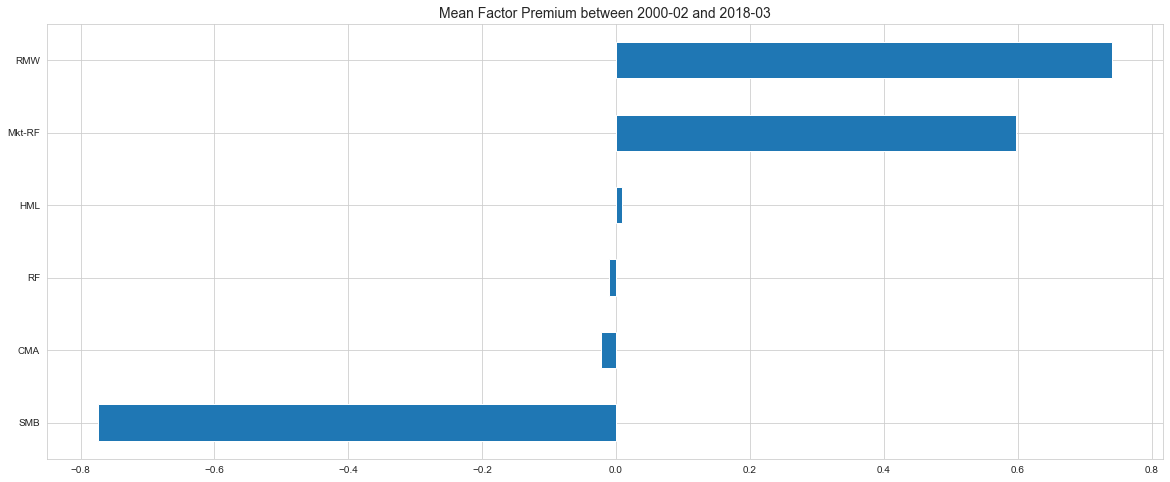

In [23]:
lambdas.mean().sort_values().plot.barh(figsize=(20,8))
plt.title(f'Mean Factor Premium between {lambdas.index[0]} and {lambdas.index[-1]}', fontsize=14);

This is interesting. It seems that **RMW** has had a bigger positive effect on each industry over the years than exposure to the market. I guess that makes sense. A company that is posting good profit numbers ought to thrive, or at least survive, even if the market doesn't do so well part of the time. Also interesting, **SMB** has a negative risk premium, indicating that big companies have outperformed small companies during this time. We may be seeing the effects of the 2008 recession clearly in this model. The other factors have very small average premia indeed.

It is important to remember the effect that the time period over which we perform this modelling can have a huge effect on the outcome of the calculations. Like I said just a paragraph ago, it is quite possible that the big financial crisis in 2008 meant that smaller companies died off, while big companies with robust operating profits were able to survive or even expand while the market as a whole faced massive losses. This explains the *unusual* (take that with a grain of salt) findings here.

## Examining Factor Premiums

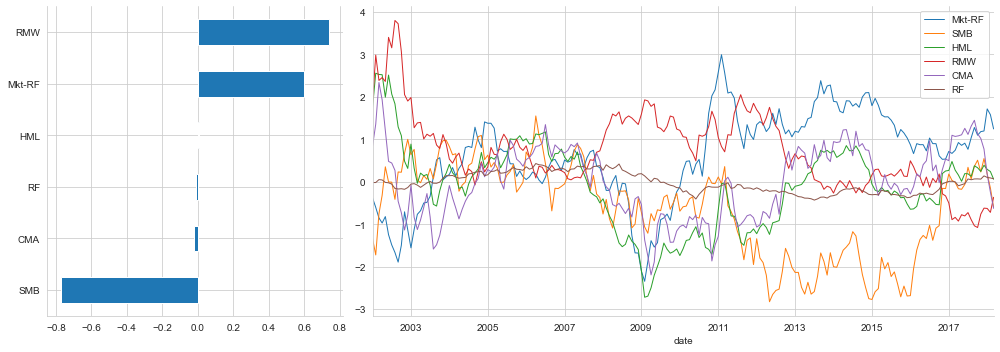

In [24]:
window = 24
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(ax=ax2,
                                             linewidth=1,
                                             figsize=(14,5))
sns.despine()
plt.tight_layout();

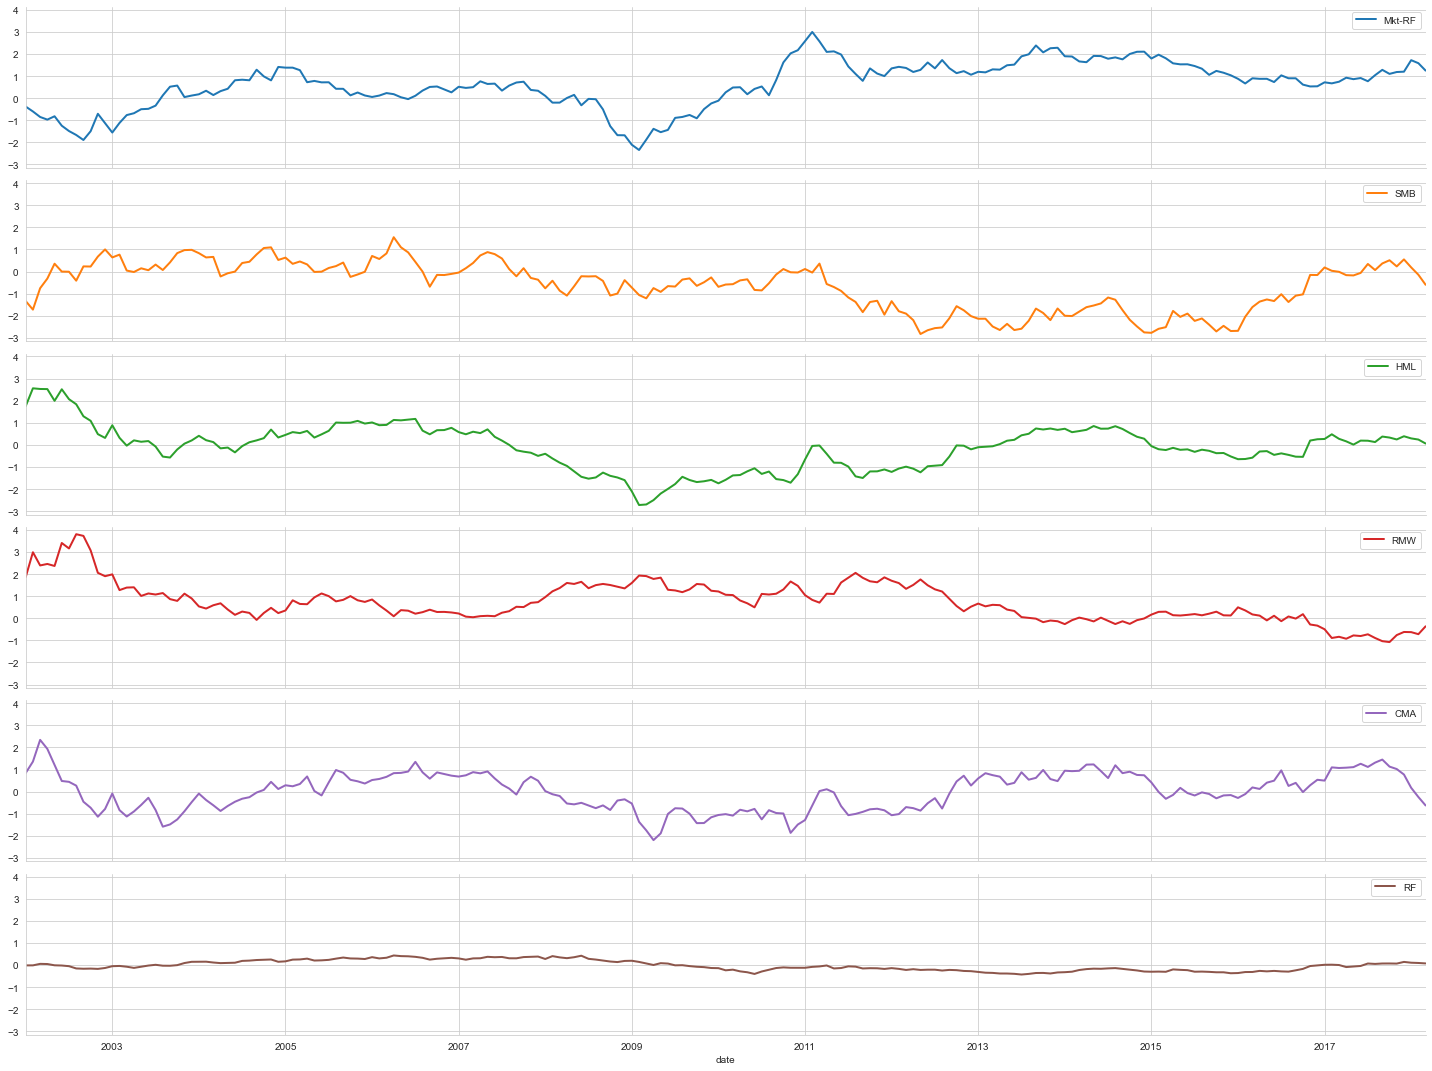

In [25]:
window = 24
lambdas.rolling(window).mean().dropna().plot(linewidth=2,
                                             figsize=(20,15),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout();

## Using the LinearModels Library

The LinearModels Python library has a built-in function that will perform Fama-Macbeth Regression for you. Super easy.

In [26]:
model = LinearFactorModel(portfolios=monthly_portfolio_data,
                          factors=monthly_factor_data)
results = model.fit()
print(results)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6723
No. Factors:                          6   J-statistic:                    12.293
No. Observations:                   218   P-value                         0.3420
Date:                  Tue, Mar 29 2022   Distribution:                 chi2(11)
Time:                          19:54:48                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5978     0.3228     1.8519     0.0640     -0.0349      1.2304
SMB           -0.7743     0.4651    

In [27]:
print(results.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6723
No. Factors:                          6   J-statistic:                    12.293
No. Observations:                   218   P-value                         0.3420
Date:                  Tue, Mar 29 2022   Distribution:                 chi2(11)
Time:                          19:54:48                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.5978     0.3228     1.8519     0.0640     -0.0349      1.2304
SMB           -0.7743     0.4651    

In [28]:
lambdas.mean()

Mkt-RF    0.597758
SMB      -0.774332
HML       0.008258
RMW       0.741411
CMA      -0.022227
RF       -0.010149
dtype: float64